<a href="https://colab.research.google.com/github/sahil-bhatia-iitbhu/deep_understanding_of_deep_learning/blob/main/04_overfitting_and_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Over Fitting and Cross Validation

### Overfitting

1. Overview
2. Techniques to control overfitting
3. Researcher Overfitting
    
    a. Also called researchers degree of freedom.

    b. The researcher has many choices for how to clean, organize, and select the data; and which models and how many models to run.

    Hence, as soon a data clean strategy and model architecture fits better than other iterations, the researcher prefers that model but that doesn't always mean that its the best model.

4. Avoid Researcher Overfitting

    a. Decide the architecture in advance, and make only minor adjustments. (Feasible for frequently-studied problems)

    b. Build a series of models but never use the test set until all models are trained (kaggle-like competition and best of new problems or new models)

### Cross-Validation

1. Overview
2. K-fold Cross validation
3. Assumption of cross-validation:

    The hold-out and test sets are independent of (uncorrelated with) the training set. If this assumption is violated, the relevance of this process is lost, and overfitting persists.

4. Conclusion:
    
    Overfitting is not intrinsically bad, overfitting reduces generizability, which may or may not be problematic depending on the goals and scope of the model.

### Regularization

1. Generalization:
    
    How well the model works well, when applied on new data.

2. Generalization Boundaries:

    The population you want the model to apply to. This concept is really important as you can't apply every model on every scenario, you need to define the boundaries of your model itself.

Hence, you could say that both over-fitting and regularization are relative to each other. The tighter the regularization boundaries, the more research overfitting you might need in regards to the data pertaining within boundaries.

Though, training overfitting should ideally be in control.

### Cross-validation : Manually

In [ ]:
# import libraries
import torch
import torch.nn as nn
import numpy as np


# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')


# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='setosa'] = 0
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

In [ ]:
#  (no devset here)

# how many training examples
propTraining = .8 # in proportion, not percent
nTraining = int(len(labels)*propTraining)
# nTraining = 120

# initialize a boolean vector to select data and labels
traintestBool = np.zeros(len(labels),dtype=bool)
# traintestBool = dataset with all FALSE

# is this the correct way to select samples?
# traintestBool[range(nTraining)] = True

# this is better, but why?
items2use4train = np.random.choice(range(len(labels)),nTraining,replace=False)
# items2use4train = random choice of index to use for training

traintestBool[items2use4train] = True

traintestBool

array([ True, False, False, False, False,  True,  True,  True, False,
        True,  True,  True,  True, False,  True,  True, False,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True, False,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True, False,  True,
       False,  True,

In [ ]:
# test whether it's balanced
print('Average of full data:')
print( torch.mean(labels.float()) ) # =1 by definition
print(' ')

print('Average of training data:')
print( torch.mean(labels[traintestBool].float()) ) # should be 1...
print(' ')

print('Average of test data:')
print( torch.mean(labels[~traintestBool].float()) ) # should also be 1...

Average of full data:
tensor(1.)
 
Average of training data:
tensor(1.)
 
Average of test data:
tensor(1.)


In [ ]:
# create the ANN model

# model architecture
ANNiris = nn.Sequential(
    nn.Linear(4,64),   # input layer
    nn.ReLU(),         # activation unit
    nn.Linear(64,64),  # hidden layer
    nn.ReLU(),         # activation unit
    nn.Linear(64,3),   # output units
      )

# loss function
lossfun = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.01)

In [ ]:
# entire dataset
print( data.shape )

# training set
print( data[traintestBool,:].shape )

# test set
print( data[~traintestBool,:].shape )

torch.Size([150, 4])
torch.Size([120, 4])
torch.Size([30, 4])


In [ ]:

# train the model

numepochs = 1000

# initialize losses
losses = torch.zeros(numepochs)
ongoingAcc = []

# loop over epochs
for epochi in range(numepochs):

  # forward pass
  yHat = ANNiris(data[traintestBool,:])

  # compute accuracy (note: denser than previous code!)
  ongoingAcc.append( 100*torch.mean(
              (torch.argmax(yHat,axis=1) == labels[traintestBool]).float()) )

  # compute loss
  loss = lossfun(yHat,labels[traintestBool])
  losses[epochi] = loss

  # backprop
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

In [ ]:
# compute train and test accuracies

# final forward pass USING TRAINING DATA
predictions = ANNiris(data[traintestBool,:])
trainacc = 100*torch.mean((torch.argmax(predictions,axis=1) == labels[traintestBool]).float())


# final forward pass USING TEST DATA!
predictions = ANNiris(data[~traintestBool,:])
testacc = 100*torch.mean((torch.argmax(predictions,axis=1) == labels[~traintestBool]).float())

In [ ]:
# report accuracies

print('Final TRAIN accuracy: %g%%' %trainacc)
print('Final TEST accuracy:  %g%%' %testacc)

Final TRAIN accuracy: 98.3333%
Final TEST accuracy:  100%


### Cross-validation using scikitlearn and experiment on share of train vs test data

In [ ]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# NEW!
from sklearn.model_selection import train_test_split


# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

In [ ]:
# create our fake dataset

fakedata = np.tile(np.array([1,2,3,4]),(10,1)) + np.tile(10*np.arange(1,11),(4,1)).T
fakelabels = np.arange(10)>4
print(fakedata), print(' ')
print(fakelabels)

[[ 11  12  13  14]
 [ 21  22  23  24]
 [ 31  32  33  34]
 [ 41  42  43  44]
 [ 51  52  53  54]
 [ 61  62  63  64]
 [ 71  72  73  74]
 [ 81  82  83  84]
 [ 91  92  93  94]
 [101 102 103 104]]
 
[False False False False False  True  True  True  True  True]


In [ ]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = \
                        train_test_split(fakedata, fakelabels, test_size=.2)

# NOTE the third input parameter above.
# This can be specified as test size or training size.
# Be mindful of which parameter is written!



# print out the sizes
print('Training data size: ' + str(train_data.shape))
print('Test data size: ' + str(test_data.shape))
print(' ')

# print out the train/test data
print('Training data: ')
print(train_data)
print(' ')

print('Test data: ')
print(test_data)

Training data size: (8, 4)
Test data size: (2, 4)
 
Training data: 
[[ 71  72  73  74]
 [101 102 103 104]
 [ 11  12  13  14]
 [ 41  42  43  44]
 [ 91  92  93  94]
 [ 21  22  23  24]
 [ 31  32  33  34]
 [ 61  62  63  64]]
 
Test data: 
[[51 52 53 54]
 [81 82 83 84]]


In [ ]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.01)

  return ANNiris,lossfun,optimizer

In [ ]:
# train the model

# global parameter
numepochs = 250

def trainTheModel(trainProp):

  # initialize losses
  losses = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # separate train from test data
  # Note 1: unique split for each epoch!
  # Note 2: here we specify the training size, not the testing size!
  X_train, X_test, y_train, y_test = train_test_split(data,labels, train_size=trainProp)

  # loop over epochs
  for epochi in range(numepochs):

    # forward pass and loss
    yHat = ANNiris(X_train)
    loss = lossfun(yHat,y_train)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # compute training accuracy
    trainAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y_train).float()).item() )

    # test accuracy
    predlabels = torch.argmax( ANNiris(X_test),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y_test).float()).item() )

  # function output
  return trainAcc,testAcc

In [ ]:
# testing the functions

# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
# NOTE: the input is the training proportion, not the test proportion!
trainAcc,testAcc = trainTheModel(.8)

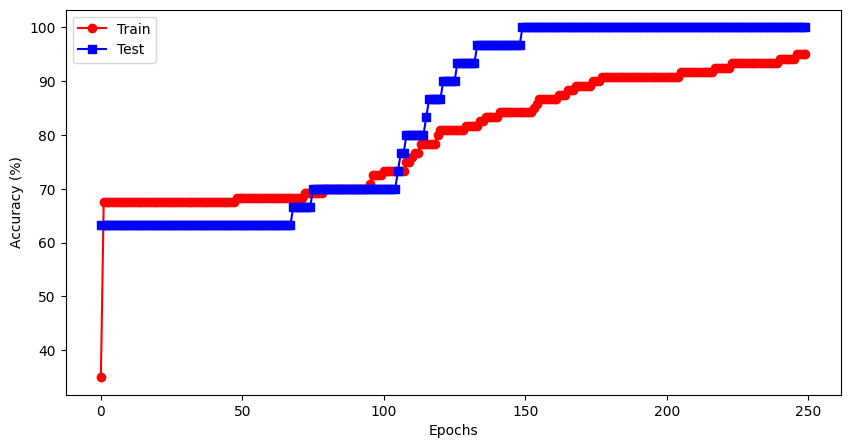

In [ ]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'ro-')
plt.plot(testAcc,'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.show()

In [ ]:
# Now the experiment

trainSetSizes = np.linspace(.2,.95,10)

allTrainAcc = np.zeros((len(trainSetSizes),numepochs))
allTestAcc = np.zeros((len(trainSetSizes),numepochs))

for i in range(len(trainSetSizes)):

  # create a model
  ANNiris,lossfun,optimizer = createANewModel()

  # train the model
  trainAcc,testAcc = trainTheModel(trainSetSizes[i])

  # store the results
  allTrainAcc[i,:] = trainAcc
  allTestAcc[i,:] = testAcc

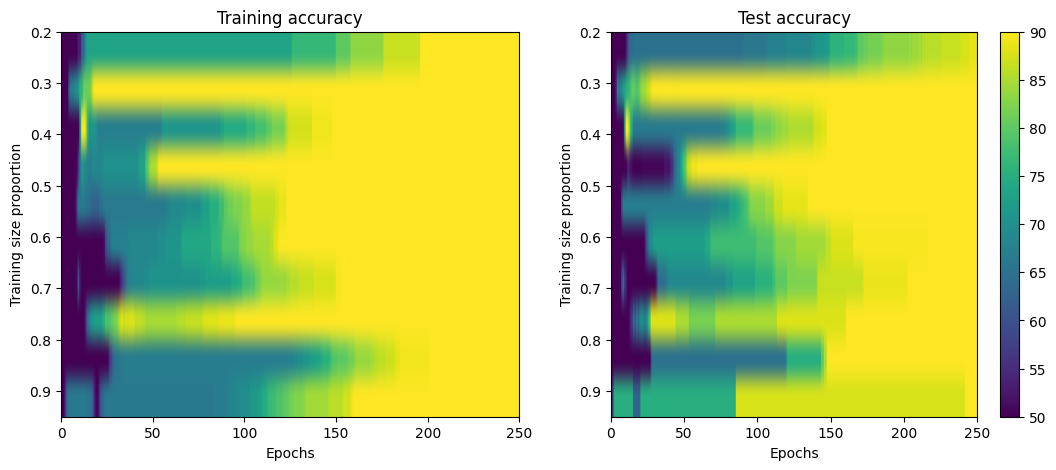

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(13,5))

ax[0].imshow(allTrainAcc,aspect='auto',
             vmin=50,vmax=90, extent=[0,numepochs,trainSetSizes[-1],trainSetSizes[0]])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training size proportion')
ax[0].set_title('Training accuracy')

p = ax[1].imshow(allTestAcc,aspect='auto',
             vmin=50,vmax=90, extent=[0,numepochs,trainSetSizes[-1],trainSetSizes[0]])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training size proportion')
ax[1].set_title('Test accuracy')
fig.colorbar(p,ax=ax[1])

plt.show()

**Conclusion**

No firm result as the dataset is too small, do try this out with a bigger dataset in future.

### PyTorch Dataloaders and Batch Size concept

Using batch to train the model:

  Instead of running backpropagation after every unit of data, instead running it on average of errors of a small bunch of data togethor. This allows stable movements and low variance due to impact of individual entries in data.

In [ ]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# new!
from torch.utils.data import DataLoader, TensorDataset


# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')


# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

In [ ]:
# use scikitlearn to split the dataset
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)

# then convert them into Pytorch datasets
train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
train_loader = DataLoader(train_data,batch_size=5,shuffle=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0],shuffle=False)

In [ ]:
# let's check through the data
print('TRAINING DATA:')
for batch, label in (train_loader):
  print(batch,label)
  print(' ')

print('TRAINING DATA:')
for batch, label in (test_loader):
  print(batch,label)
  print(' ')

TRAINING DATA:
tensor([[5.7000, 2.6000, 3.5000, 1.0000],
        [5.8000, 2.7000, 5.1000, 1.9000],
        [5.1000, 3.7000, 1.5000, 0.4000],
        [6.1000, 2.9000, 4.7000, 1.4000],
        [5.6000, 2.7000, 4.2000, 1.3000]]) tensor([1, 2, 0, 1, 1])
 
tensor([[6.4000, 3.2000, 4.5000, 1.5000],
        [4.7000, 3.2000, 1.3000, 0.2000],
        [6.1000, 2.6000, 5.6000, 1.4000],
        [5.5000, 2.3000, 4.0000, 1.3000],
        [4.8000, 3.0000, 1.4000, 0.1000]]) tensor([1, 0, 2, 1, 0])
 
tensor([[5.7000, 2.5000, 5.0000, 2.0000],
        [6.5000, 3.0000, 5.8000, 2.2000],
        [7.2000, 3.2000, 6.0000, 1.8000],
        [5.9000, 3.0000, 4.2000, 1.5000],
        [6.3000, 2.8000, 5.1000, 1.5000]]) tensor([2, 2, 2, 1, 2])
 
tensor([[5.0000, 3.0000, 1.6000, 0.2000],
        [7.7000, 3.0000, 6.1000, 2.3000],
        [6.4000, 3.1000, 5.5000, 1.8000],
        [6.2000, 3.4000, 5.4000, 2.3000],
        [4.9000, 3.1000, 1.5000, 0.2000]]) tensor([0, 2, 2, 2, 0])
 
tensor([[6.4000, 2.9000, 4.3000, 1.30

In [ ]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.01)

  return ANNiris,lossfun,optimizer

In [ ]:
# train the model

# global parameter
numepochs = 500

def trainTheModel():

  # initialize accuracies as empties (not storing losses here)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):


    # loop over training data batches
    batchAcc = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item())
    # end of batch loop...


    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append(np.mean(batchAcc))

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

  # function output
  return trainAcc,testAcc

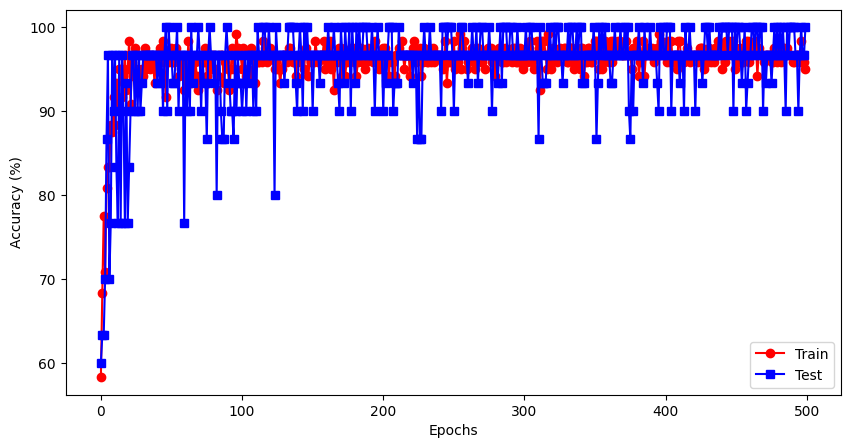

In [ ]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
trainAcc,testAcc = trainTheModel()



# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'ro-')
plt.plot(testAcc,'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])

# optional zoom-in to final epochs
# plt.xlim([300,500])
# plt.ylim([90,100.5])

plt.show()

### Regularization

1. Penalize "memorization"
2. Helps the model generalize to unseen examples
3. Changes the representations of learning (either more sparse or more distributed depending on the regularizer)

**Other observations:**
1. Can increase or decrease training time
2. Can decrease training accuracy but increase generalization
3. Work better for large models with multiple hidden layers
4. Generally works better with sufficient data

**Three families of regularizers**

1. Node Regularization : Modify the model (dropout)
2. Loss Regularization : Add a cost to the loss function (L1/L2)
3. Data Regularization : MOdify or add data (batch training, data augmentation)

**Dropout Regularization**

Dropout reduces the overall activation during training (fewer elements in the weighted sum). This creates an imbalance between the activation units while training vs evaluation/testing.

To resolve the issue there are 2 ways :
1. Scale up the weights during training (Pytorch method)
2. Scale down the weights during testing

**Effects of Dropout:**
1. Prevents the single node from learning too much
2. Forces the model to have distributed representations
3. Makes the model less reliant on individual nodes and thus more stable.

**Other observations:**
- Generally required more training (through eahc epoch computes faster)
- Improves generalization (obviously)
- Works better on deep networks
- Work better with sufficient data, but if data is well structured and sampled then not required.

In [3]:
# Dropout example

import torch
import torch.nn as nn
import torch.nn.functional as F

# define a dropout instance and make some data
prob = .5

dropout = nn.Dropout(p=prob) # note this is pulled from nn
x = torch.ones(10)

# let's see what dropout returns
y = dropout(x)
print(x)
print(y)#*(1-prob))
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([2., 0., 0., 2., 2., 2., 0., 2., 2., 0.])
tensor(1.2000)


Note:

1. (1-prob) would prove the Pytorch scales up during training
2. Variable average on each hit proves that the probability is not hard bound, but is empirical and is applied on each node where it acts like a switch for each node which has 50% probability of switching on and off.

In [4]:
# dropout is turned off when evaluating the model
dropout.eval()
y = dropout(x)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [5]:
# annoyingly, F.dropout() is not deactivated in eval mode:

dropout.eval()
y = F.dropout(x)
print(y)
print(torch.mean(y))

# but you can manually switch it off
# dropout.eval()
y = F.dropout(x,training=False)
print(y)
print(torch.mean(y))

tensor([2., 2., 0., 2., 2., 0., 2., 0., 2., 0.])
tensor(1.2000)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [8]:
# the model needs to be reset after toggling into eval mode

dropout.train()
y = dropout(x)
print(y) # with dropout


dropout.eval()
y = dropout(x)
print(y) # without dropout


# dropout.train()
y = dropout(x)
print(y) # still w/o dropout ;)

tensor([2., 2., 2., 2., 2., 2., 2., 0., 0., 0.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


### Dropout Regularization Implementation and Experiment